<a href="https://colab.research.google.com/github/marcusborela/Aprendizado-Profundo-Unicamp/blob/main/question_answering_Sinan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT for question/answering

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 91.9 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 6.6 MB 69.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 4.2 MB/s 
     |████████████████████████████████| 212 kB 96.3 MB/s 
     |████████████████████████████████| 140 kB 79.7 MB/s 
     |████████████████████████████████| 1.1 MB 89.6 MB/s 
     |████████████████████████████████| 127 kB 98.0 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 271 kB 89.9 MB/s 
     |████████████████████████████████| 144 kB 88.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
from transformers import BertTokenizerFast, BertForQuestionAnswering, pipeline, \
                         DataCollatorWithPadding, TrainingArguments, Trainer, \
                         AutoModelForQuestionAnswering, AutoTokenizer
from datasets import Dataset
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

In [5]:
!pwd

/content


In [ ]:
!cd drive/MyDrive/ia025/qa

In [2]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased', return_token_type_ids=True)

qa_bert = BertForQuestionAnswering.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-large-uncased

In [21]:
qa_bert

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12,

In [7]:
qa_df = pd.read_csv('drive/MyDrive/ia025/qa/qa.csv')

qa_df.shape

(29989, 5)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
qa_df.head()

,question,context,start_positions,end_positions,answer
0,What sare the benifts of the blood brain barrir?,Another approach to brain function is to exami...,56,60,isolated from the bloodstream
1,What is surrounded by cerebrospinal fluid?,Another approach to brain function is to exami...,16,16,brain
2,What does the skull protect?,Another approach to brain function is to exami...,11,11,brain
3,What has been injected into rats to produce pr...,Another approach to brain function is to exami...,153,153,chemicals
4,What can cause issues with how the brain works?,Another approach to brain function is to exami...,93,94,brain damage


In [9]:
qa_df.iloc[0]

question            What sare the benifts of the blood brain barrir?
context            Another approach to brain function is to exami...
start_positions                                                   56
end_positions                                                     60
answer                                 isolated from the bloodstream
Name: 0, dtype: object

In [10]:
# index 56, 57, 58, 59, and 60 including question while encoding
bert_tokenizer.decode(bert_tokenizer.encode(qa_df.iloc[0].question, qa_df.iloc[0].context)[56:61])

'isolated from the bloodstream'

In [11]:
# only grab 1,000 examples
qa_dataset = Dataset.from_pandas(qa_df.sample(1000, random_state=42))

# Dataset has a built in train test split method
qa_dataset = qa_dataset.train_test_split(test_size=0.2)

In [12]:
# standard preprocessing here with truncation on to truncate longer text
def preprocess(data):
    return bert_tokenizer(data['question'], data['context'], truncation=True)

qa_dataset = qa_dataset.map(preprocess, batched=True)

Parameter 'function'=<function preprocess at 0x7f7f3261ce60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
# freeze all but the last 2 encoder layers in BERT to speed up training
for name, param in qa_bert.bert.named_parameters():
    if 'encoder.layer.22' in name:
        break
    param.requires_grad = False  # disable training in BERT

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

In [16]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='drive/MyDrive/ia025/qa/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='drive/MyDrive/ia025/qa/logs',
    save_strategy='epoch',
    logging_steps=10,
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)


In [17]:

trainer = Trainer(
    model=qa_bert,
    args=training_args,
    train_dataset=qa_dataset['train'],
    eval_dataset=qa_dataset['test'],
    data_collator=data_collator
)

# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: answer, question, context, __index_level_0__. If answer, question, context, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 5.820552825927734,
 'eval_runtime': 7.3857,
 'eval_samples_per_second': 27.079,
 'eval_steps_per_second': 0.948}

In [22]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: answer, question, context, __index_level_0__. If answer, question, context, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Epoch,Training Loss,Validation Loss
1,5.187400,4.949744
2,4.677500,4.801077


The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: answer, question, context, __index_level_0__. If answer, question, context, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


Saving model checkpoint to drive/MyDrive/ia025/qa/results/checkpoint-25
Configuration saved in drive/MyDrive/ia025/qa/results/checkpoint-25/config.json
Model weights saved in drive/MyDrive/ia025/qa/results/checkpoint-25/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: answer, question, context, __index_level_0__. If answer, question, context, __index_level_0__ are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 32
Saving model checkpoint to drive/MyDrive/ia025/qa/results/checkpoint-50
Configuration saved in drive/MyDrive/ia025/qa/results/checkpoint-50/config.json
Model weights saved in drive/MyDrive/ia025/qa/results/checkpoint-50/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from drive/MyDrive/ia

TrainOutput(global_step=50, training_loss=5.02140869140625, metrics={'train_runtime': 93.9915, 'train_samples_per_second': 17.023, 'train_steps_per_second': 0.532, 'total_flos': 1026801668171520.0, 'train_loss': 5.02140869140625, 'epoch': 2.0})

In [ ]:
# Q/A models are very large and take a long time to fine-tune

In [18]:
trainer.save_model()

Saving model checkpoint to drive/MyDrive/ia025/qa/results
Configuration saved in drive/MyDrive/ia025/qa/results/config.json
Model weights saved in drive/MyDrive/ia025/qa/results/pytorch_model.bin


In [19]:
pipe = pipeline("question-answering", 'drive/MyDrive/ia025/qa/results', tokenizer=bert_tokenizer)

loading configuration file drive/MyDrive/ia025/qa/results/config.json
Model config BertConfig {
  "_name_or_path": "drive/MyDrive/ia025/qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file drive/MyDrive/ia025/qa/results/config.json
Model config BertConfig {
  "_name_or_path": "drive/MyDrive/ia025/qa/results",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention

In [20]:
pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'answer': 'Sinan lives in California',
 'end': 25,
 'score': 0.010317944921553135,
 'start': 0}

In [23]:
princeton = """In 1675, a Quaker missionary from England, encouraged by New Jersey proprietors John Lord 
              "Berkeley and Sir George Carteret, arrived to establish a settlement in this area near the 
              "Delaware River, which was inhabited by the Lenni-Lenape Indians. The Keith survey of 1685 
              "established the western boundary of Middlesex and Somerset Counties and later, the Township 
              "of Princeton. Today Keith's Line is recognized as Province Line Road. With the laying of the 
              "cornerstone for Nassau Hall in 1754, Princeton began its development as a location for 
              "quality education. Nassau Hall was named for William III, Prince of Orange-Nassau. This simple stone 
              "edifice was one of the largest public buildings in the colonies and became a model for many other 
              "structures in New Jersey and Pennsylvania."""

pipe("What survey led to the founding of Princeton?", princeton)

{'answer': 'and Somerset Counties and later, the Township \n              "of Princeton',
 'end': 438,
 'score': 0.00011329932021908462,
 'start': 364}

In [24]:
PERSON = 'Sinan Ozdemir'

# Note this is NOT an efficient way to search on google. This is done simply for education purposes
google_html = BeautifulSoup(requests.get(f'https://www.google.com/search?q={PERSON}').text).get_text()[:512]

pipe(f'Who is {PERSON}?', google_html)

{'answer': ');break a}a=!',
 'end': 473,
 'score': 4.7814352001296356e-05,
 'start': 460}

# Finetuning made our model better at our specific dataset but loses quality in general Q/A

In [25]:
# From Huggingface: https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad

squad_pipe = pipeline("question-answering", "bert-large-uncased-whole-word-masking-finetuned-squad")

https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmptv0_3nvd


Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
creating metadata file for /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "cla

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e
creating metadata file for /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e
loading weights file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/28a060c1e2e1216bd9c8f5222ce38ce916c4829b8b05e027fe91510f3fd4da7e.50fc4a146342b3a6a99b185af3d5b70163b64d45790be64d9124dcccbcd3915e
All model checkpoint weights were used when initializing BertForQuestionAnswering.

All the weights of BertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/b9f8d92aa5a32cfe504c3524c173dc611dbe81d49392f40601286b94ee1e1169.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/b9f8d92aa5a32cfe504c3524c173dc611dbe81d49392f40601286b94ee1e1169.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmphz4flrn7


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/9b7535fe1c0da28aa7cc66b7f34529d984f535c401be8352f6adeb25f7870def.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/9b7535fe1c0da28aa7cc66b7f34529d984f535c401be8352f6adeb25f7870def.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/68e5260dea718cdc2daf27dc106fd8741636b03e3173b5492e57a7fa525ca33b.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/9b7535fe1c0da28aa7cc66b7f34529d984f535c401be835

In [26]:
squad_pipe("Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.")

{'answer': 'California', 'end': 25, 'score': 0.9924461245536804, 'start': 15}

In [27]:
squad_pipe("What survey led to the founding of Princeton?", princeton)

{'answer': 'The Keith survey',
 'end': 293,
 'score': 0.3114524185657501,
 'start': 277}

In [28]:
squad_pipe(f'Who is {PERSON}?', google_html)

{'answer': 'Google', 'end': 22, 'score': 0.9498475790023804, 'start': 16}

In [29]:
# visualize logits
large_tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

qa_input = large_tokenizer(  # tokenize our example
    "Where is Sinan living these days?", "Sinan lives in California but Matt lives in Boston.",
    return_tensors='pt'
)

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file http

In [30]:
large_qa_bert = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

output = large_qa_bert(**qa_input)  # pass the input through our QA model
output

loading configuration file https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/402f6d8c99fdd3bffd354782842e2b5a6be81f80ab630591051ebc78ca726f39.ebffac96fee44dbe30674c204dd3d3f358c1b8c33100281ecdd688514f41410a
Model config BertConfig {
  "_name_or_path": "bert-large-uncased-whole-word-masking-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights f

QuestionAnsweringModelOutput([('start_logits',
                               tensor([[-5.4601, -6.2255, -7.8363, -7.1762, -8.4660, -6.4108, -6.7524, -8.1289,
                                        -8.7000, -5.4599,  0.6538, -2.8565, -1.1788,  1.0216,  7.0426, -5.2244,
                                        -1.3684, -5.9469, -4.9360, -0.0566, -5.4591, -5.4591]],
                                      grad_fn=<CloneBackward0>)),
                              ('end_logits',
                               tensor([[-1.0355, -5.8719, -5.9027, -7.3427, -5.7653, -6.1145, -6.2080, -5.3895,
                                        -5.7630, -1.0352, -4.9416, -3.3419, -4.7643, -3.9473,  7.5046, -1.7702,
                                        -2.6509, -5.6540, -5.9817,  1.0278, -1.0357, -1.0406]],
                                      grad_fn=<CloneBackward0>))])

In [31]:
token_labels = large_tokenizer.convert_ids_to_tokens(qa_input['input_ids'].squeeze())

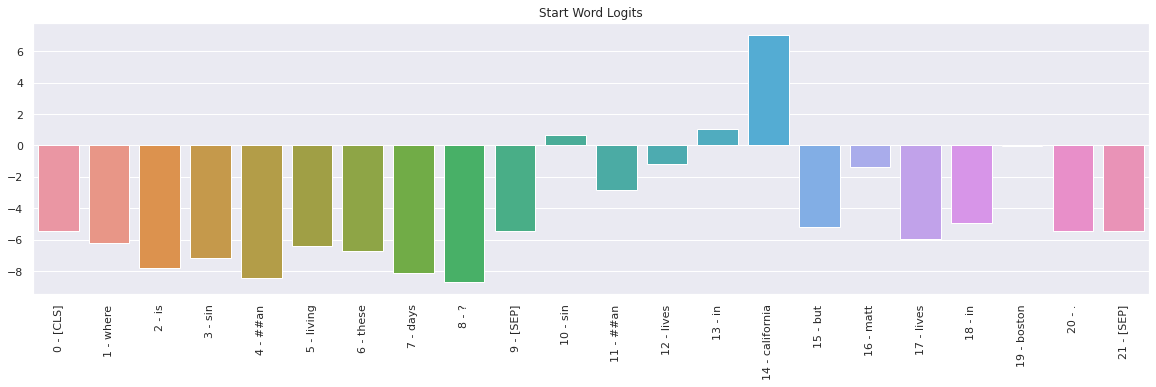

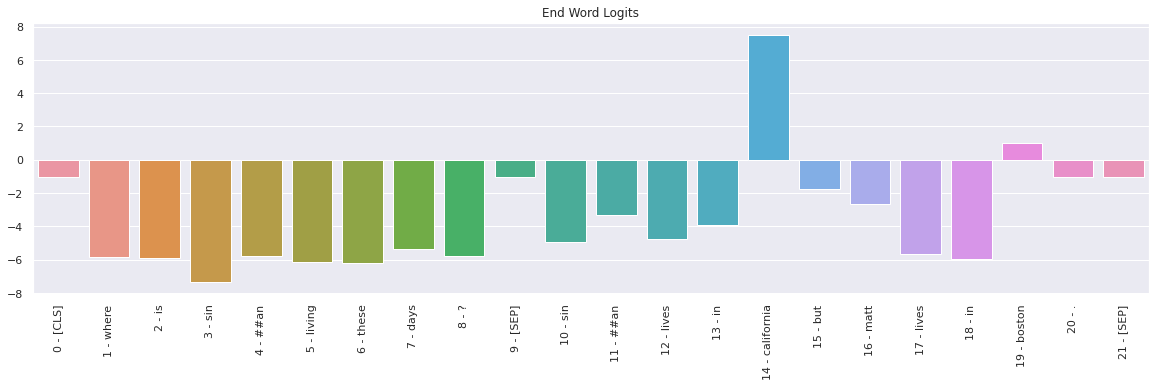

In [32]:
# Plot start and end logits for our fine-tuned model

sns.set(rc={"figure.figsize":(20, 5)}) 

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.start_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('Start Word Logits')

plt.show()

# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=[f'{i} - {t}' for i, t in enumerate(token_labels)], y=output.end_logits.squeeze().tolist(), ci=None)
# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# Turn on the vertical grid to help align words to scores.
plt.title('End Word Logits')

plt.show()